In [1]:
import fimdp
fimdp.setup()
from fimdp import io as fi2st
from fimdp.objectives import AS_REACH, BUCHI
from fimdp.energy_solvers import BasicES

import stormpy

import pandas as pd

In [2]:
def buchi_storm(storm_mdp):
    formula = 'Pmax>=1 [G Pmax>=1 [F "target" & Pmax>=1 [F "reload"]]]'
    prop = stormpy.parse_properties(formula)
    
    return stormpy.model_checking(storm_mdp, prop[0])

In [3]:
def buchi_fimdp(mdp, capacity, targets):
    solver = BasicES(mdp, capacity, targets)
    fimdp_res = solver.compute(BUCHI)

In [4]:
def create_gw(size, capacity):

    constants = {
        "size_x" : size,
        "size_y" : "size_x",
        "capacity" : capacity,
        "cons_w_ex" : 0,
        "cons_s_ex" : 0,
    }

    return fi2st.prism_to_consmdp("../tests/prism_models/gw_param.prism", constants=constants, return_targets=True)

In [10]:
def benchmark_on_gw(size_range, cap_range):
    df = pd.DataFrame(columns=["size", "capacity", "cmdp_size", "mdp_size", "fimdp_time", "storm_time"])

    for size in size_range:
        for capacity in cap_range:
            cap = int(capacity*size)
            print(f"size={size} and capacity={cap}")
            res = {
                "size": size,
                "capacity": cap,
            }

            mdp, targets = create_gw(size, cap)
            res["cmdp_size"] = mdp.num_states

            st_mdp = fi2st.encode_to_stormpy(mdp, cap, targets)
            res["mdp_size"] = st_mdp.nr_states

            fimdp_time = %timeit -o -q buchi_fimdp(mdp, cap, targets)
            res["fimdp_time"] = fimdp_time.average
            storm_time = %timeit -o -q buchi_storm(st_mdp)
            res["storm_time"] = storm_time.average

            df = df.append(res, ignore_index=True)
    return df

In [11]:
results = {}
results["small"] = benchmark_on_gw(range(20, 40, 5), [1.5, 3, 5, 7])

<class 'int'>
size=20 and capacity=30
<class 'int'>
size=20 and capacity=60
<class 'int'>
size=20 and capacity=100
<class 'int'>
size=20 and capacity=140
<class 'int'>
size=25 and capacity=37
<class 'int'>
size=25 and capacity=75
<class 'int'>
size=25 and capacity=125
<class 'int'>
size=25 and capacity=175
<class 'int'>
size=30 and capacity=45
<class 'int'>
size=30 and capacity=90
<class 'int'>
size=30 and capacity=150
<class 'int'>
size=30 and capacity=210
<class 'int'>
size=35 and capacity=52
<class 'int'>
size=35 and capacity=105
<class 'int'>
size=35 and capacity=175
<class 'int'>
size=35 and capacity=245


In [12]:
results

{'small':     size  capacity  cmdp_size  mdp_size  fimdp_time  storm_time
 0   20.0      30.0      400.0   12311.0    0.135127    0.130298
 1   20.0      60.0      400.0   24221.0    0.325324    0.576361
 2   20.0     100.0      400.0   40101.0    0.340390    1.058053
 3   20.0     140.0      400.0   55981.0    0.307945    1.529513
 4   25.0      37.0      625.0   23603.0    0.352567    0.264008
 5   25.0      75.0      625.0   47201.0    0.683504    1.193468
 6   25.0     125.0      625.0   78251.0    0.667485    2.132290
 7   25.0     175.0      625.0  109301.0    0.647047    3.044733
 8   30.0      45.0      900.0   41221.0    0.525546    0.562553
 9   30.0      90.0      900.0   81541.0    1.082917    2.502661
 10  30.0     150.0      900.0  135301.0    1.422985    5.213867
 11  30.0     210.0      900.0  189061.0    1.063951    6.530665
 12  35.0      52.0     1225.0   64718.0    0.543993    1.085821
 13  35.0     105.0     1225.0  129431.0    1.609247    5.670015
 14  35.0     17

<AxesSubplot:xlabel='storm_time', ylabel='fimdp_time'>

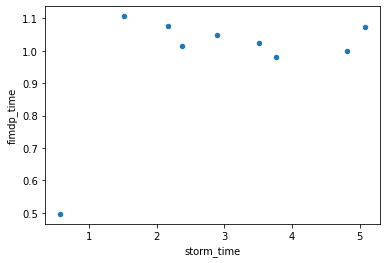

In [21]:
df.set_index(["size","capacity"]).loc[30].plot("storm_time", "fimdp_time", kind="scatter")

In [30]:
df.set_index(["size","capacity"]).loc[45].round(1)

,cmdp_size,mdp_size,fimdp_time,storm_time
capacity,,,,
67.0,2025.0,137366.0,2.2,2.3
89.0,2025.0,181806.0,3.5,7.1
111.0,2025.0,226246.0,4.3,8.6
133.0,2025.0,270686.0,3.4,10.1
155.0,2025.0,315126.0,3.4,12.1
177.0,2025.0,359566.0,3.4,14.1


<AxesSubplot:xlabel='storm_time', ylabel='fimdp_time'>

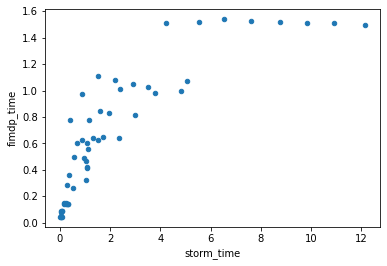

In [11]:
df.plot("storm_time", "fimdp_time", kind="scatter")